In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pickle import dump
from sklearn.utils import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from collections import OrderedDict

combined_data = pd.read_hdf("../source_files/combined_data_C1.hdf5")

INPUT_COLUMNS = ["start_speed", "spin_rate", "spin_dir", "zone", "pitch_type"]
CONTEXT_COLUMNS = ["b_score", "p_score", "b_count", "s_count", "outs", "pitch_num", \
    "on_1b", "on_2b", "on_3b", "inning", "p_throws", "stand", "top"]
OUTPUT_COLUMNS = ["at_bat_score"]

inputs = combined_data[INPUT_COLUMNS].copy()
context = combined_data[CONTEXT_COLUMNS].copy()

#------------- One-Hot Encode  -----------------
inputs = pd.concat([inputs, pd.get_dummies(inputs.pitch_type)], axis=1)
inputs = inputs.drop(labels="pitch_type", axis=1)

context[["p_throws", "stand"]] = context[["p_throws", "stand"]] == "R"
context[["p_throws", "stand", "top"]] = context[["p_throws", "stand", "top"]].astype(int)
context = context.rename(columns={"p_throws":"p_isrighty", "stand":"b_isrighty", "top":"is_top_inning"})

combined_inputs = pd.concat([inputs, context], axis=1)
#Normalization
scaler = StandardScaler().fit(combined_inputs)
combined_inputs = scaler.transform(combined_inputs)
dump(scaler, open('scaler.pkl', 'wb'))

# nn_data = pd.concat([combined_inputs, combined_data[OUTPUT_COLUMNS]], axis=1)
# nn_data.to_hdf("../source_files/model_data.hdf5", key="df")

combined_inputs = torch.tensor(combined_inputs)
outputs = torch.tensor(combined_data[OUTPUT_COLUMNS].values)



In [7]:
class FFNetPytorch(nn.Module):
  def __init__(self, input_size, output_size, hl1=100, hl2=25):
    super(FFNetPytorch, self).__init__()
    '''
    Define the layers of the neural network. One hidden layer and output layer.
    The activation function used in between the two layers is sigmoid.
    '''
    self.layer1 = nn.Linear(input_size, hl1, bias = True)
    self.layer2 = nn.Linear(hl1, hl2, bias = True)
    self.layer3 = nn.Linear(hl2, output_size, bias=True)

    self.double()
    

  def forward(self, x):
    '''
    :param x: input to the model (N, NUM_FEATURES)

    :return:
      output: logits of the last layer of the model 
    '''
    x = torch.sigmoid(self.layer1(x))
    x = torch.sigmoid(self.layer2(x))
    x = self.layer3(x)

    return x

class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, i):
    return self.X[i, ...], self.Y[i]
  
  def __len__(self):
    return self.X.shape[0]


Training

In [67]:
def trainNN(HIDDEN1_SIZE, HIDDEN2_SIZE):
  #------------- Train --------------
  X_train, X_test, Y_train, Y_test = \
      train_test_split(combined_inputs, outputs, test_size=0.2, random_state=42)

  NUM_FEATURES = X_train.shape[1]
  NUM_CLASSES = 1

  # HIDDEN1_SIZE = 4
  # HIDDEN2_SIZE = 4

  batch_size = 512
  max_epochs = 80

  print_every = 1
  test_every = 1
  SAVE_EVERY = 10

  LR = 1e-3


  SAVE_MODEL = True
  LOAD_MODEL = True
  SAVE_PATH = "HL2_" + str(HIDDEN1_SIZE) + "_" + str(HIDDEN2_SIZE)
  MODEL_SAVE_PATH = "models/" + SAVE_PATH + ".pt"
  TRAIN_LOSSES_SAVE_PATH = "trainingloss/" + SAVE_PATH + ".csv"
  TEST_LOSSES_SAVE_PATH = "testloss/" + SAVE_PATH + ".csv"
  ACCURACY_SAVE_PATH = "accuracies/" + SAVE_PATH + ".csv"

  CONV_SIZE = 10 #CONVERGENCE_WINDOW_SIZE
  CONVERGENCE_THRESHOLD = 0.0003

  model = FFNetPytorch(NUM_FEATURES, NUM_CLASSES, hl1=HIDDEN1_SIZE, hl2=HIDDEN2_SIZE)
  train_losses =[]
  test_losses=[]
  train_accuracies = []

  if LOAD_MODEL:
      try:
        model = torch.load(MODEL_SAVE_PATH)
        train_losses = np.fromfile(TRAIN_LOSSES_SAVE_PATH, sep=',').tolist()
        test_losses = np.fromfile(TEST_LOSSES_SAVE_PATH, sep=',').tolist()
        train_accuracies = np.fromfile(ACCURACY_SAVE_PATH, sep=',').tolist()
      except FileNotFoundError:
        pass
    
  #print(model)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
  loss_fn = nn.MSELoss()
  #torch.manual_seed(314159)
  device = "cpu"

  dataset_train = CustomDataset(X_train, Y_train)
  dataset_test = CustomDataset(X_test, Y_test)

  model = model.to(device)
  train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

  accuracies = []
  max_epoch = max_epochs + len(train_losses)
  train_dif = 0
  epoch = len(train_losses)

  while epoch < max_epoch and (train_dif > CONVERGENCE_THRESHOLD or train_dif == 0):
    batch_losses = []
    batch_accuracies = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      prediction = torch.round(output)
      accuracy = torch.sum(prediction == target)/len(target)
      loss.backward()
      optimizer.step()
      batch_losses.append(loss.item())
      batch_accuracies.append(accuracy.item())
    
    #if epoch > 3: scheduler.step()
    test_accuracy = torch.mean(torch.Tensor(batch_accuracies)).item()
    accuracies.append(test_accuracy)
    train_losses.append(torch.mean(torch.Tensor(batch_losses)).item())
    train_dif = (np.max(train_losses[-CONV_SIZE:])-np.min(train_losses[-CONV_SIZE:]))/np.mean(train_losses[-CONV_SIZE:])

    model.eval()
    batch_losses = []

    if epoch % test_every == 0:
      for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        batch_losses.append(loss.item())

      test_losses.append(torch.mean(torch.Tensor(batch_losses)).item())

    if epoch % SAVE_EVERY == 0:
      print("----- SAVED -----")
      torch.save(model, MODEL_SAVE_PATH)
      np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
      np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
      np.asarray(accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')

    if epoch % print_every == 0:
      print('{epoch}/{max_epoch}, Train Loss: {loss:.6f}, Test Loss: {test_loss:.6f}, Accuracy: {accuracy:.4f}%, Difference {diff:.3f}%, lr: {lr}'.format(
                  epoch=epoch, max_epoch=max_epoch, loss=train_losses[-1], test_loss=test_losses[-1], \
                  accuracy = test_accuracy*100, diff=train_dif*100, lr=scheduler.get_last_lr()[0]))

    epoch += 1

  if SAVE_MODEL:
    torch.save(model, MODEL_SAVE_PATH)
    np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
    np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
    np.asarray(accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')
    

for i in range (4, 5):
  for j in range (1, min(i+1, 4)):
    print("STARTING WRAPPER", 2**i, 2**j)
    trainNN(2**i, 2**j)

STARTING WRAPPER 8 2
39/119, Train Loss: 3.099088, Test Loss: 3.094438, Accuracy: 14.2275%, Difference 0.029%, lr: 0.001
STARTING WRAPPER 8 4
----- SAVED -----
30/110, Train Loss: 3.099490, Test Loss: 3.096516, Accuracy: 14.2443%, Difference 0.023%, lr: 0.001
STARTING WRAPPER 8 8
----- SAVED -----
40/120, Train Loss: 3.097934, Test Loss: 3.096603, Accuracy: 13.8634%, Difference 0.032%, lr: 0.001
41/120, Train Loss: 3.098044, Test Loss: 3.093777, Accuracy: 13.9100%, Difference 0.032%, lr: 0.001
42/120, Train Loss: 3.098003, Test Loss: 3.094716, Accuracy: 13.8864%, Difference 0.032%, lr: 0.001
43/120, Train Loss: 3.098217, Test Loss: 3.096658, Accuracy: 13.9200%, Difference 0.032%, lr: 0.001
44/120, Train Loss: 3.097563, Test Loss: 3.095798, Accuracy: 13.9130%, Difference 0.044%, lr: 0.001


KeyboardInterrupt: 

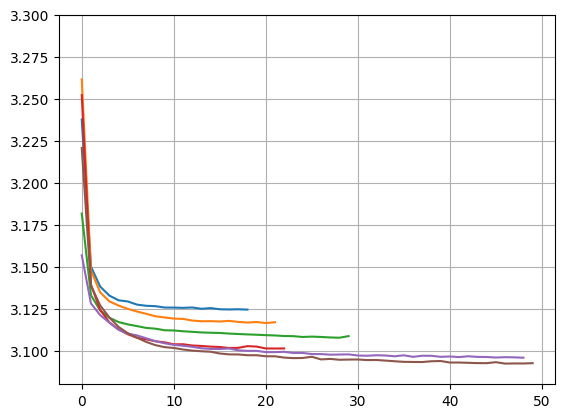

In [60]:
import matplotlib.pyplot as plt


#training_4_1 = np.fromfile("trainingloss/HL2_4_1.csv", sep=',').tolist()

training_64_1 = np.fromfile("trainingloss/HL2_64_1.csv", sep=',').tolist()
testing_64_1 = np.fromfile("testloss/HL2_64_1.csv", sep=',').tolist()

plt.figure()
for i in range(0,6):
    plt.plot(np.fromfile("trainingloss/HL2_" + str(2**i) + "_1.csv", sep=',').tolist())
plt.grid()
plt.ylim(3.08, 3.3)
plt.show()

In [ ]:
x = [2**i for i in range(0, 8)]
y = [2**i for i in range(0, 8)]

pltplt.pcolormesh([x,y], 1)

In [72]:
trainNN(16,8)

1/81, Train Loss: 3.121940, Test Loss: 3.117505, Accuracy: 15.3925%, Difference 0.550%, lr: 0.001
2/81, Train Loss: 3.116470, Test Loss: 3.114399, Accuracy: 14.6352%, Difference 0.726%, lr: 0.001
3/81, Train Loss: 3.112777, Test Loss: 3.112650, Accuracy: 13.9692%, Difference 0.845%, lr: 0.001
4/81, Train Loss: 3.108550, Test Loss: 3.105921, Accuracy: 13.6967%, Difference 0.981%, lr: 0.001
5/81, Train Loss: 3.105656, Test Loss: 3.105742, Accuracy: 13.5755%, Difference 1.075%, lr: 0.001
6/81, Train Loss: 3.103043, Test Loss: 3.100019, Accuracy: 13.6409%, Difference 1.160%, lr: 0.001
7/81, Train Loss: 3.101528, Test Loss: 3.100286, Accuracy: 13.7525%, Difference 1.209%, lr: 0.001
8/81, Train Loss: 3.100747, Test Loss: 3.097204, Accuracy: 13.7983%, Difference 1.234%, lr: 0.001
9/81, Train Loss: 3.099756, Test Loss: 3.096334, Accuracy: 13.8566%, Difference 1.267%, lr: 0.001
----- SAVED -----
10/81, Train Loss: 3.099944, Test Loss: 3.099832, Accuracy: 13.9271%, Difference 0.714%, lr: 0.001
1